In [1]:
%pylab inline

import seaborn as sns
sns.set_style('white')

import pandas as pd

import torch
import torch.nn as nn

from datasets.cmnist_dist import make_joint_distribution
from utils.distribution import DiscreteDistribution, compute_ce, compute_kl
from models.training import train
from models.encoders import DiscreteEncoder
from utils.plot import plot_data

Populating the interactive namespace from numpy and matplotlib


# Data distribution

We will use the y-CMNIST data distribution as an example in this notebook, which defines a joint distribution of digits $d$, color $c$, pictures $x$, environments $e$, labels $y$ and selection $t$.
The binary selection variable $t$ indicates if the data is selected for training $t=1$ or not $t=0$.

In [2]:
# Create the joint distribution for y-CMNIST (CMNIST or d-CMNIST are also available)
dist = make_joint_distribution('y-CMNIST')

print('Joint distribution: %s' %dist)

Joint distribution: p(y,e,d,x,c,t)


The joint distribution factorizes as $p(y,e,d,x,c,t) = p(y|d)p(e)p(d)p(c|y,e)p(x|c,d)p(t|e)$.
Train and test distributions are created by conditioning on $t=1$ and $t=0$, respectively.

In [3]:
# Create the training distribution by selecting t=1
train_dist = dist.condition_on('t',1)

# Create the test distribution by selecting t=0
test_dist = dist.condition_on('t',0)

print('Train distribution: %s' %train_dist)
print('Test distribution: %s' %test_dist)

Train distribution: p(y,e,d,x,c|t=1)
Test distribution: p(y,e,d,x,c|t=0)


We can describe how distant the train and test distributions are by computing $I(xy;t)$, which represents how much information the selection carries about the joint distribution of raw features (pictures $s$) and targets (labels $y$). The distribution shift can be seen as the joint effect of covariate shift $I(t;x)$ and concept shift $I(y;t|x)$:

$$\underbrace{I(xy;t)}_{\text{distribution shift}} = \underbrace{I(x;t)}_{\text{covariate shift}} + \underbrace{I(y;t|x)}_{\text{concept shift}}$$

In [4]:
# Compute the amout of distribution shift I(xy;t)
print('Distribution shift: %f nats' %(dist.compute('I(x,y;t)')))

# Compute the amout of concept shift I(y;t|x)
print('Concept shift: %f nats' %(dist.compute('I(y;t|x)')))

# Compute the amout of concept shift I(x;t)
print('Covariate shift: %f nats' %(dist.compute('I(x;t)')))

Distribution shift: 0.306607 nats
Concept shift: 0.237813 nats
Covariate shift: 0.068793 nats


Note that the selection $t$ does induce concept shift, therefore a maximum likelihood solution must result in positive OOD error.
Given a model $q(y|x)$ that is optimal on the training distribution $p(y|x,t=1)$ we have:
$$ KL(p(y|x,t=0)||q(y|x))\ge \frac{1}{1-\alpha} I(y;t|x) > 0 $$

# Introducing a Latent representation

The out of distribution error for a model that is composed by an encoder $q(z|x)$ and classifier $q(y|z)$ is upper bounded by the $\textit{Test Information Loss}$, which represents the amount of information lost trhough the encoding procedure (in red), and $\textit{Latent Out Of Distribution error}$ (in blue) which represents the error when using the latent features $z$ instead of the original observations $x$:
$$\underbrace{KL(p(y|x,t=0)||q(y|x))}_{OOD Error}\le \underbrace{I_{t=0}(x;y|z)}_{\text{Test Information Loss}} + \underbrace{KL(p(y|z,t=0)||q(y|z))}_{\text{Latent OOD Error}}$$
Clearly, considering an identity encoder, which maps each observation into itself, the OOD error is equivalent to the Latent OOD error. This also happens for any encoder $q(z|x)$ that retains all the predictive information.

q(y|x)=p(y|x,t=1)
Lower-bound : 0.356720 nats
OOD error: 1.249681 nats


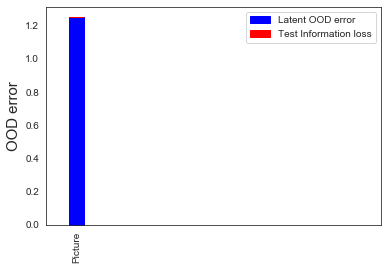

In [5]:
data = []

# define alpha as the minimum probability between p(t=0) and p(t=1)
alpha = dist.marginal('t').p.min()

# Consider a model q(y|x) that matches the train distribution p(y|x,t=1)
q_y_x = train_dist.conditional('y','x')
print('q(y|x)=%s' % q_y_x)

# Compute the lower bound I(y;t|x)/(1-alpha)
l_bound = dist.compute('I(y;t|x)')/(1-alpha)

# Compute the OOD error for q(y|x): KL(p(y|x,t=0)||q(y|x))
ood_error = compute_kl(test_dist, q_y_x)

print('Lower-bound : %f nats' % l_bound)
print('OOD error: %f nats' % ood_error)

data.append({
    'Model': 'Picture',
    'Test Information Loss': 0,
    'Latent OOD error': ood_error.item()
})

f, ax = plt.subplots(1,1)
plot_data(data, ax)

We compute and visualize the components of the OOD error for models that build representations based on color $c$, digit $d$ or no information (prior). Since the two marginal label distributions $p(y|t=0)$ and $p(y|t=1)$ are equivalent, the error of a model that discards all the information is entirely due to information loss, and the corresponding latent OOD error is zero. Note that a model that relies on color information (discarding anying about the digits) incurs in a higher OOD error, while a model that discards color information is able to minimize the latent OOD error, while retaining some predictive information.

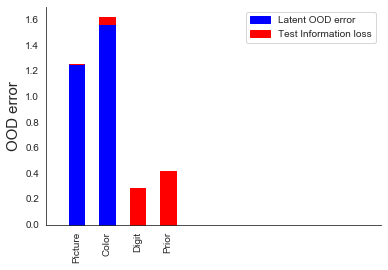

In [6]:
models = []

# Color
data.append({
    'Model': 'Color',
    'Latent OOD error': compute_kl(test_dist, train_dist.conditional('y','c')),
    'Test Information Loss': test_dist.mi('y','x','c')
})

# Digit
data.append({
    'Model': 'Digit',
    'Latent OOD error': compute_kl(test_dist, train_dist.conditional('y','d')),
    'Test Information Loss': test_dist.mi('y','x','d')
})

# Prior
data.append({
    'Model': 'Prior',
    'Latent OOD error': compute_kl(test_dist, train_dist.marginal('y')),
    'Test Information Loss': test_dist.mi('y','x')
})

f, ax = plt.subplots(1,1)
sns.despine()
plot_data(data, ax)

As a next step, we introduce randomly initialize an encoder $q(z|x)$ and measure the compoments of the OOD error. Usually most of the information is discarded even and the latent OOD error is small.

q(y|z)=p(y|z,t=1)
OOD error: 0.470260
Latent OOD error: 0.470260
Test Infomation Loss: 0.385006


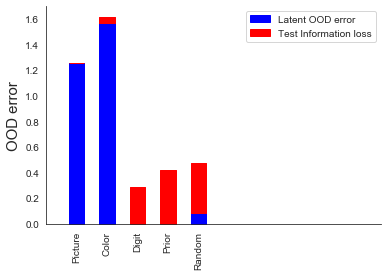

In [7]:
# Create an encoder which maps each 'x' into a latent 'z' which consists of 64 different values
encoder = DiscreteEncoder(z_dim=64)

# Define an classifier q(y|z)=p(y|z,\t=1) that is optimal on training
q_y_z = encoder(train_dist).conditional('y','z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])
print('q(y|z)=%s' % q_y_z)

# Compute the OOD error of the model q(y|z)
ood_error = compute_kl(latent_test_dist, q_y_z, cond_1='x')
print('OOD error: %f' % ood_error)

# Compute the latent OOD error of the model q(y|z)
lat_ood_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
print('Latent OOD error: %f' % ood_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)


data.append({
    'Model': 'Random', 
    'Latent OOD error': lat_ood_error.item(), 
    'Test Information Loss': test_info_loss.item()
})


f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()


The goal is to train the encoder $q(z|x)$ to minimize the latent OOD error while retaining maximal predictive information. We analuze different families of objectives in literature. Each of them present a loss in the form:
$$\mathcal{L}(\lambda) = \mathbb{E}_{t=1}[-\log q(y|z)]+ \lambda \mathcal{R}(q(z|x)),$$
in which the first term aims to maximize the amount of predictive information in the representation, while the second is a regularization term that aims to reduce the latent OOD error.
The trade-off between the two objectives is regulated by the hyper-parameter $\lambda$. DIfferent regularization will be based on the observation of an environment variable $e$, which represents the factor(s) on which the selection is based on.

# Model Training

Here we explore the effect of training a latent representation using the following criteria:
- Independence $\mathcal{R}(q(z|x))=I(e;z)$
- Sufficiency $\mathcal{R}(q(z|x))=I(e;y|z)$
- Separation $\mathcal{R}(q(z|x))=I(e;z|y)$

## Independence Criterion

We train the model using the regularization prescribed by the independence criterion until convergence


Done


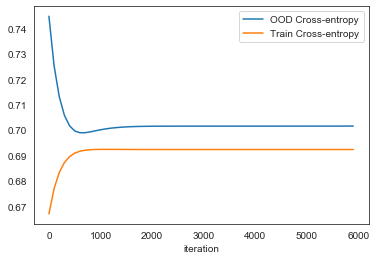

In [8]:
from models.criteria import IndependenceCriterion

# re-initialize the encoder
encoder = DiscreteEncoder(z_dim=64)

# Use the Independence criterion for training with a strong regularization $\lambda=10^6$
criterion = IndependenceCriterion(reg=1e6)

# Train until convergence, logging train and test cross entropy
logs = train(encoder, criterion, 
             train_dist=train_dist.marginal(['x','y','e']), # train distribution
             test_dist=test_dist.marginal(['x','y']),       # test distribution      
             verbose=True)

# Visualize the logs
pd.DataFrame(logs).plot(x='iteration')

We can compute the value of the regularization term $I(e;z)$ at the end of the training. We can notice that the independence constraint is correctly enforced on training but there is a small dependency left when considering the unselected (original) distribution.

In [9]:
# Compute the value of I(e;z) on for the trained model for the train distribution
print('I(e;z) on train = %f nats' % encoder(train_dist).mi('e','z'))

# Compute the value of I(e;z) on for the trained model
print('I(e;z) on test = %f nats' % encoder(dist).mi('e','z'))

I(e;z) on train = 0.000000 nats
I(e;z) on test = 0.004239 nats


We visualize the error compoments after convergence. Even if constraint is correctly enforced on train, the separation criterion does not result in minimal OOD error

Latent OOD error: 0.470260
Test Infomation Loss: 0.378356


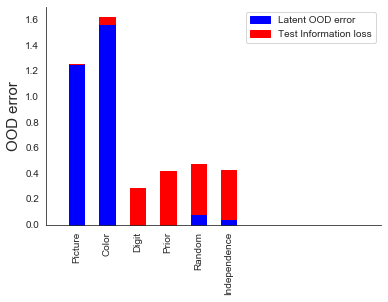

In [10]:
# Compute the latent OOD error of the model q(y|z)
q_y_z = encoder(train_dist).conditional('y','z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])
lat_ood_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
print('Latent OOD error: %f' % ood_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)

data.append({
    'Model': 'Independence', 
    'Latent OOD error': lat_ood_error.item(), 
    'Test Information Loss': test_info_loss.item()
})

# Plot the results
f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()

## Sufficiency Criterion

We re-initialize the encoder and train it using the sufficiency criterion


Distance: 0.007311>0.000100



Distance: 0.002215>0.000100



Distance: 0.001125>0.000100



Distance: 0.000667>0.000100



Distance: 0.000425>0.000100



Distance: 0.000186>0.000100



Distance: 0.000102>0.000100



Done


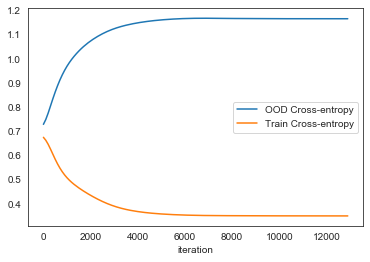

In [11]:
from models.criteria import SufficiencyCriterion

# re-initialize the encoder
encoder = DiscreteEncoder(z_dim=64)

# Use the Sufficiency criterion for training with a strong regularization $\lambda=10^6$
criterion = SufficiencyCriterion(reg=1e6)

# Train until convergence, logging train and test cross entropy
logs = train(encoder, criterion, 
             train_dist=train_dist.marginal(['x','y','e']), # train distribution
             test_dist=test_dist.marginal(['x','y']),       # test distribution      
             verbose=True)

# Visualize the logs
pd.DataFrame(logs).plot(x='iteration')

Note that despite the long training, the model is not able to create a representation that satisfies the sufficiency constraint $ I(e;y|z)=0 $ on training (such representation does not exist for the d-CMNIST dataset

In [12]:
# Compute the value of I(e;z) on for the trained model for the train distribution
print('I(e;y|z) on train = %f' % encoder(train_dist).mi('e','y','z'))

# Compute the value of I(e;z) on for the trained model
print('I(e;y|z) = %f' % encoder(dist).mi('e','y','z'))

I(e;y|z) on train = 0.034146
I(e;y|z) = 0.133106


Once again the resulting model is not optimal in terms of OOD error

Latent OOD error: 0.470260
Test Infomation Loss: 0.381897


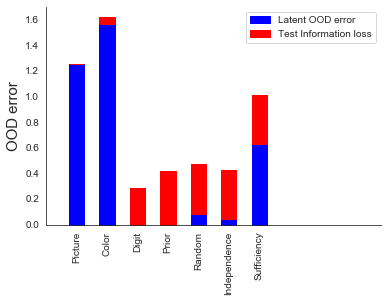

In [13]:
# Compute the latent OOD error of the model q(y|z)
q_y_z = encoder(train_dist).conditional('y','z')
lat_ood_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])
print('Latent OOD error: %f' % ood_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)


data.append({
    'Model': 'Sufficiency', 
    'Latent OOD error': lat_ood_error.item(), 
    'Test Information Loss': test_info_loss.item()
})

# Plot the results
f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()

## Separation Criterion

We repeat the same procedure by applying the separation criterion instead


Distance: 0.000647>0.000100



Distance: 0.001122>0.000100



Distance: 0.002027>0.000100



Distance: 0.003918>0.000100



Distance: 0.008251>0.000100



Distance: 0.016565>0.000100



Distance: 0.024811>0.000100



Distance: 0.026518>0.000100



Distance: 0.022821>0.000100



Distance: 0.017338>0.000100



Distance: 0.013102>0.000100



Distance: 0.009769>0.000100



Distance: 0.007200>0.000100



Distance: 0.005264>0.000100



Distance: 0.003765>0.000100



Distance: 0.002632>0.000100



Distance: 0.001800>0.000100



Distance: 0.001221>0.000100



Distance: 0.000825>0.000100



Distance: 0.000550>0.000100



Distance: 0.000371>0.000100



Distance: 0.000247>0.000100



Distance: 0.000164>0.000100



Distance: 0.000109>0.000100



Done


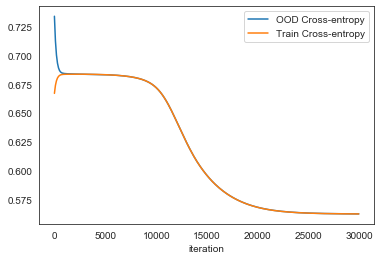

In [14]:
from models.criteria import SeparationCriterion

# re-initialize the encoder
encoder = DiscreteEncoder(z_dim=64)

# Use the Sufficiency criterion for training with a strong regularization $\lambda=10^6$
criterion = SeparationCriterion(reg=1e6)

# Train until convergence, logging train and test cross entropy
logs = train(encoder, criterion, 
             train_dist=train_dist.marginal(['x','y','e']), # train distribution
             test_dist=test_dist.marginal(['x','y']),       # test distribution      
             verbose=True)

# Visualize the logs
pd.DataFrame(logs).plot(x='iteration')

Once again, we check if the model manages to enforce the separation constraint $I(e;z|y)=0$

In [15]:
# Compute the value of I(e;z) on for the trained model for the train distribution
print('I(e;z|y) on train = %f' % encoder(train_dist).mi('e','z','y'))

# Compute the value of I(e;z) on for the trained model
print('I(e;z|y) = %f' % encoder(dist).mi('e','z','y'))

I(e;z|y) on train = 0.000000
I(e;z|y) = -0.000000


Note that the model that enforces the separation criterion is the only one that minimizes the overall OOD error on the y-CMNIST dataset

Latent OOD error: 0.470260
Test Infomation Loss: 0.285903


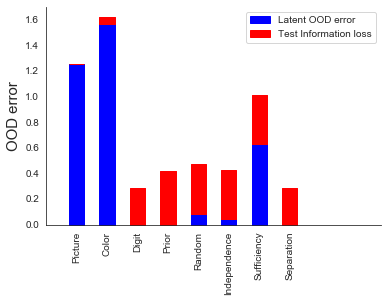

In [16]:
# Compute the latent OOD error of the model q(y|z)
q_y_z = encoder(train_dist).conditional('y','z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])
lat_ood_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
print('Latent OOD error: %f' % ood_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)


data.append({
    'Model': 'Separation', 
    'Latent OOD error': lat_ood_error.item(), 
    'Test Information Loss': test_info_loss.item()
})

# Plot the results
f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()

The other experiments reported in the paper can be repliated by changing the data-generating distribution reported at the beginning of this notebook